In [ ]:
# Libraries

# Data manipulation
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Decision Tree and Random Forest classifiers
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# **1. Data Loading and Preprocessing**

This step imports the SZVAV dataset, which contains HVAC system measurements and ground truth fault labels. The dataset will be used for training and evaluating fault detection models. The initial dataset consisted of 15,839 records and 16 variables, collected at one-minute intervals from a Single-Zone Variable Air Volume (SZVAV) Air Handling Unit (AHU). These variables included air temperature measurements, damper and valve control signals, system operation indicators, and a binary label indicating the presence or absence of faults. 

In [2]:
# Load the dataset from CSV
df_0 = pd.read_csv('SZVAV.csv')
df_0

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
0,9/11/2017 0:00,72.29,NaN,NaN,81.11,78.56,76.38,1,0.1,0.00,1.00,-0.04,0.0,0.23,0,1
1,9/11/2017 0:01,72.30,NaN,NaN,81.11,78.56,76.39,1,0.1,0.00,1.00,-0.04,0.0,0.23,0,1
2,9/11/2017 0:02,72.37,NaN,NaN,81.09,78.56,76.38,1,0.1,0.00,1.00,-0.04,0.0,0.22,0,1
3,9/11/2017 0:03,72.29,NaN,NaN,81.06,78.51,76.38,1,0.1,0.00,1.00,-0.04,0.0,0.22,0,1
4,9/11/2017 0:04,71.82,NaN,NaN,81.05,78.41,76.37,1,0.1,0.00,1.00,-0.04,0.0,0.24,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15834,9/24/2017 23:54,71.59,72.5,72.5,65.05,74.65,73.42,1,0.1,0.11,0.89,0.07,0.0,0.00,0,0
15835,9/24/2017 23:55,71.58,72.5,72.5,65,74.63,73.42,1,0.1,0.11,0.89,0.06,0.0,0.00,0,0
15836,9/24/2017 23:56,71.58,72.5,72.5,64.93,74.59,73.43,1,0.1,0.11,0.89,0.06,0.0,0.00,0,0
15837,9/24/2017 23:57,71.57,72.5,72.5,64.85,74.59,73.41,1,0.1,0.11,0.89,0.06,0.0,0.00,0,0


**Dataset Overview:** We inspect the dataset structure, including the number of entries, column types, and presence of missing values.

In [3]:
# Display dataset information (column types, non-null counts, etc.)
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Datetime                                       15839 non-null  object 
 1   AHU: Supply Air Temperature                    15839 non-null  float64
 2   AHU: Supply Air Temperature Heating Set Point  15249 non-null  float64
 3   AHU: Supply Air Temperature Cooling Set Point  15249 non-null  float64
 4   AHU: Outdoor Air Temperature                   15839 non-null  object 
 5   AHU: Mixed Air Temperature                     15839 non-null  float64
 6   AHU: Return Air Temperature                    15839 non-null  float64
 7   AHU: Supply Air Fan Status                     15839 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal       15839 non-null  float64
 9   AHU: Outdoor Air Damper Control Signal         158

**Drop Irrelevant Columns:** Columns like timestamps and control setpoints are not relevant for the fault classification task and will be removed.

In [4]:
# Drop columns that are not relevant for analysis
df = df_0.drop(columns=[
    'Datetime',
    'AHU: Supply Air Temperature Heating Set Point',
    'AHU: Supply Air Temperature Cooling Set Point'
])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AHU: Supply Air Temperature                 15839 non-null  float64
 1   AHU: Outdoor Air Temperature                15839 non-null  object 
 2   AHU: Mixed Air Temperature                  15839 non-null  float64
 3   AHU: Return Air Temperature                 15839 non-null  float64
 4   AHU: Supply Air Fan Status                  15839 non-null  int64  
 5   AHU: Supply Air Fan Speed Control Signal    15839 non-null  float64
 6   AHU: Outdoor Air Damper Control Signal      15839 non-null  float64
 7   AHU: Return Air Damper Control Signal       15839 non-null  float64
 8   AHU: Exhaust Air Damper Control Signal      15839 non-null  float64
 9   AHU: Cooling Coil Valve Control Signal      15839 non-null  float64
 10  AHU: Heati

**Check for Missing Values:** Before proceeding with modeling, we check for and report any missing values in the dataset.

In [5]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 AHU: Supply Air Temperature                   0
AHU: Outdoor Air Temperature                  0
AHU: Mixed Air Temperature                    0
AHU: Return Air Temperature                   0
AHU: Supply Air Fan Status                    0
AHU: Supply Air Fan Speed Control Signal      0
AHU: Outdoor Air Damper Control Signal        0
AHU: Return Air Damper Control Signal         0
AHU: Exhaust Air Damper Control Signal        0
AHU: Cooling Coil Valve Control Signal        0
AHU: Heating Coil Valve Control Signal        0
Occupancy Mode Indicator                      0
Fault Detection Ground Truth                  0
dtype: int64


**Remove Missing Data:** Rows with any missing values are dropped to ensure data quality.

In [6]:
# Drop rows with any missing values
df = df.dropna()
missing_values = df.isnull().sum()


**Data Preparation for Modeling:** All non-target columns are converted to numeric types. We then split the dataset into training and testing sets for model development.

In [7]:
# Convert all columns to numeric format, except the target variable
for col in df.columns:
    if col != 'Fault Detection Ground Truth':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Separate features (X) and target (y)
X = df.drop(columns=['Fault Detection Ground Truth'])
y = df['Fault Detection Ground Truth']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display updated dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AHU: Supply Air Temperature                 15839 non-null  float64
 1   AHU: Outdoor Air Temperature                15838 non-null  float64
 2   AHU: Mixed Air Temperature                  15839 non-null  float64
 3   AHU: Return Air Temperature                 15839 non-null  float64
 4   AHU: Supply Air Fan Status                  15839 non-null  int64  
 5   AHU: Supply Air Fan Speed Control Signal    15839 non-null  float64
 6   AHU: Outdoor Air Damper Control Signal      15839 non-null  float64
 7   AHU: Return Air Damper Control Signal       15839 non-null  float64
 8   AHU: Exhaust Air Damper Control Signal      15839 non-null  float64
 9   AHU: Cooling Coil Valve Control Signal      15839 non-null  float64
 10  AHU: Heati

# **2. DECISION TREE PRE-PRUNING**

This section focuses on building and evaluating a Decision Tree model with pre-pruning techniques. We tune the model using grid search to find the best combination of hyperparameters and then assess its performance using various evaluation tools.

**Hyperparameter Tuning using Grid Search:** We define a range of values for max_depth, min_samples_split, and min_samples_leaf to control the complexity of the tree (pre-pruning). GridSearchCV is used to identify the best combination based on 5-fold cross-validation accuracy.

In [8]:
# Define the base Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [25, 30, 35, 40, 45, None],
    'min_samples_split': [2, 5, 10, 0.01, 0.05], 
    'min_samples_leaf': [1, 5, 10, 0.01, 0.05]  
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model found by GridSearchCV
best_model = grid_search.best_estimator_
dt_preds = best_model.predict(X_test)

# Print the best hyperparameter combination
print("\n-> Best hyperparameter combination (Pre-pruning): ")
print(grid_search.best_params_)

# Evaluate the performance of the best pre-pruned Decision Tree
print("\n-> Decision Tree Results (Best Pre-pruned):")
print("Accuracy:", accuracy_score(y_test, dt_preds))
print("\n-> Classification Report (Pre-pruned):")
print(classification_report(y_test, dt_preds))


Fitting 5 folds for each of 150 candidates, totalling 750 fits

-> Best hyperparameter combination (Pre-pruning): 
{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}

-> Decision Tree Results (Best Pre-pruned):
Accuracy: 0.9810606060606061

-> Classification Report (Pre-pruned):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1703
           1       0.99      0.98      0.99      3049

    accuracy                           0.98      4752
   macro avg       0.98      0.98      0.98      4752
weighted avg       0.98      0.98      0.98      4752



**Confusion Matrix:** The confusion matrix shows the number of correct and incorrect predictions made by the model, broken down by class.

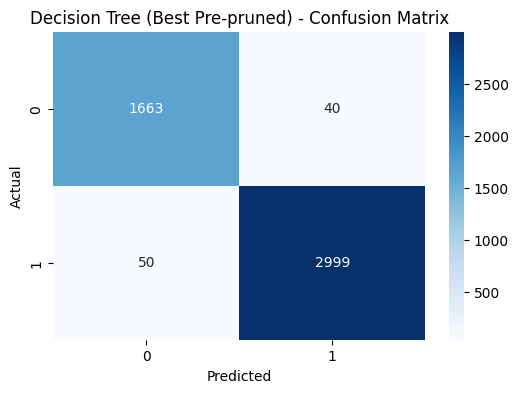

In [9]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, dt_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree (Best Pre-pruned) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Tree Visualization (Top Levels):** We visualize the first few levels of the trained decision tree for interpretability.

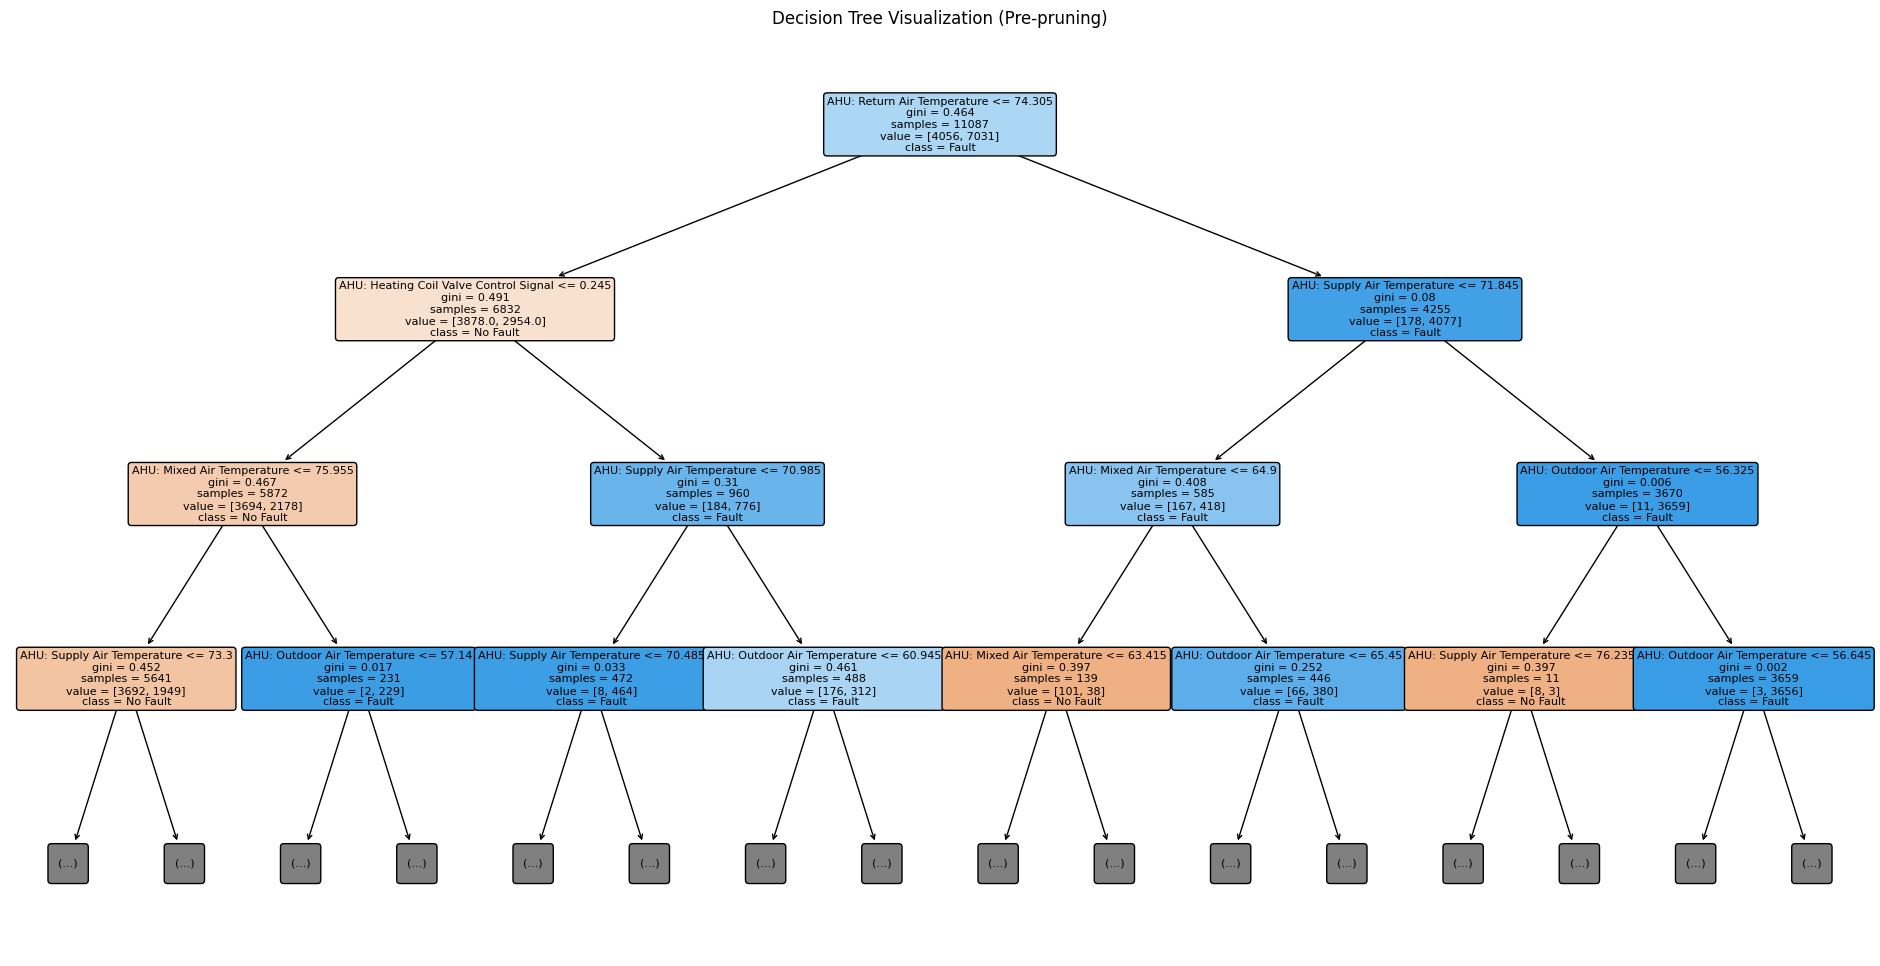

In [10]:
# Visualize the top levels of the best decision tree (pre-pruned)
plt.figure(figsize=(24, 12))
plot_tree(
    best_model, 
    feature_names=X.columns, 
    class_names=["No Fault", "Fault"],
    filled=True,
    max_depth=3,
    fontsize=8,
    rounded=True
)

plt.title("Decision Tree Visualization (Pre-pruning)")
plt.show()


**Textual Representation of Tree Rules:** This block displays the decision rules in plain text to further aid in interpretability.

In [11]:
tree_rules = export_text(best_model, feature_names=list(X.columns))
print(tree_rules)

|--- AHU: Return Air Temperature <= 74.31
|   |--- AHU: Heating Coil Valve Control Signal <= 0.24
|   |   |--- AHU: Mixed Air Temperature <= 75.95
|   |   |   |--- AHU: Supply Air Temperature <= 73.30
|   |   |   |   |--- AHU: Supply Air Temperature <= 66.74
|   |   |   |   |   |--- AHU: Mixed Air Temperature <= 73.93
|   |   |   |   |   |   |--- AHU: Outdoor Air Damper Control Signal   <= 0.11
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- AHU: Outdoor Air Damper Control Signal   >  0.11
|   |   |   |   |   |   |   |--- AHU: Cooling Coil Valve Control Signal <= 0.37
|   |   |   |   |   |   |   |   |--- AHU: Heating Coil Valve Control Signal <= 0.08
|   |   |   |   |   |   |   |   |   |--- AHU: Outdoor Air Temperature <= 61.24
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- AHU: Outdoor Air Temperature >  61.24
|   |   |   |   |   |   |   |   |   |   |--- AHU: Cooling Coil Valve Control Signal <= 0.00
|   |   |   | 

**Tree Structure Summary:** We print basic structural information such as depth and number of leaf nodes to understand the size of the tree.

In [12]:
# Display general information about the structure of the best decision tree
print("Tree Depth:", best_model.get_depth())
print("Number of Leaf Nodes:", best_model.get_n_leaves())



Tree Depth: 25
Number of Leaf Nodes: 219


**Feature Importance Plot:** We compute and visualize the importance of each feature in making predictions.

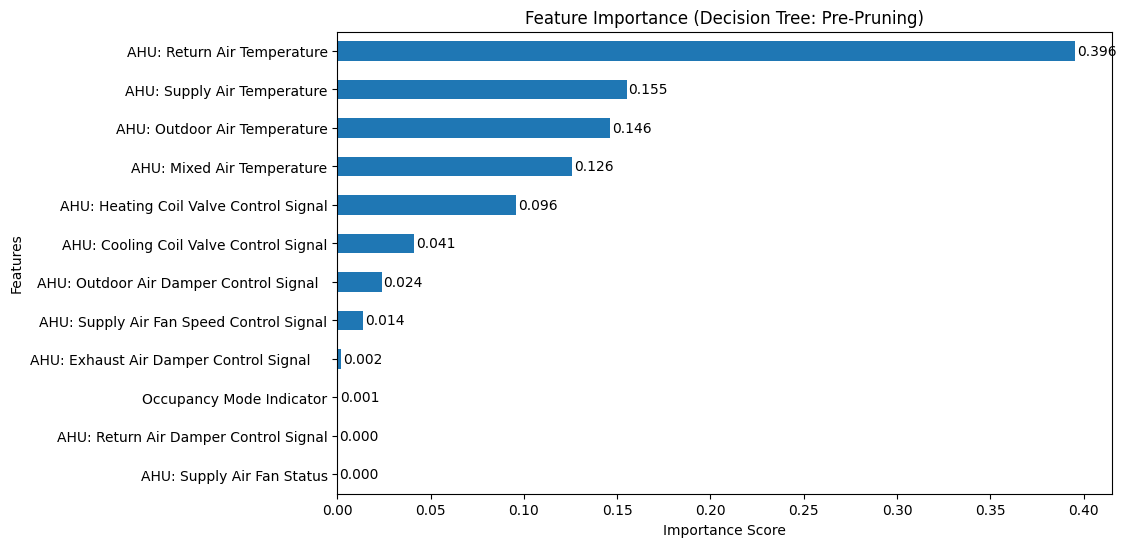

In [13]:
# Calculate and plot feature importances from the best decision tree model
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

ax = importances_sorted.plot(kind='barh', figsize=(10, 6))

# Annotate each bar with its importance score
for i, v in enumerate(importances_sorted):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.title('Feature Importance (Decision Tree: Pre-Pruning)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()




# **3. DECISION TREE POS-PRUNING**

In this section, we apply cost-complexity pruning (post-pruning) to simplify the decision tree by reducing overfitting. We identify the optimal ccp_alpha value by evaluating model accuracy on the test set across different pruning levels.

**Generate Post-Pruning Path:** We start by generating a sequence of ccp_alpha values using cost-complexity pruning. Each value corresponds to a subtree candidate.

In [14]:
# Generate the pruning path using cost-complexity pruning
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

**Train Models for Each Alpha:** We train a separate decision tree for each ccp_alpha and store the models for later evaluation.

In [15]:
# Train a decision tree for each ccp_alpha value
models = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    models.append(clf)

**Evaluate Test Accuracy for All Pruned Trees:** Each trained model is evaluated on the test set. The model with the highest accuracy is selected as the final pruned model.

In [16]:
# Evaluate test accuracy for each model
test_acc = [accuracy_score(y_test, model.predict(X_test)) for model in models]

# Select the model with the best accuracy
best_index = test_acc.index(max(test_acc))
dt_model = models[best_index]
dt_preds = dt_model.predict(X_test)

# Print model characteristics and evaluation metrics
print(f"-> Hyperparameter combination (Post-pruned):")
print({
    'depth': dt_model.get_depth(),
    'samples_leaf': dt_model.min_samples_leaf,
    'samples_split': dt_model.min_samples_split
})
print("\n-> Decision Tree Results (Post-Pruned):")
print(f"Best ccp_alpha: {ccp_alphas[best_index]:.5f}")
print("Accuracy:", accuracy_score(y_test, dt_preds))
print("\n-> Classification Report (Post-pruned):")
print(classification_report(y_test, dt_preds))


-> Hyperparameter combination (Post-pruned):
{'depth': 26, 'samples_leaf': 1, 'samples_split': 2}

-> Decision Tree Results (Post-Pruned):
Best ccp_alpha: 0.00017
Accuracy: 0.9814814814814815

-> Classification Report (Post-pruned):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1703
           1       0.99      0.98      0.99      3049

    accuracy                           0.98      4752
   macro avg       0.98      0.98      0.98      4752
weighted avg       0.98      0.98      0.98      4752



**Confusion Matrix:** We visualize the confusion matrix of the post-pruned model to assess classification performance.

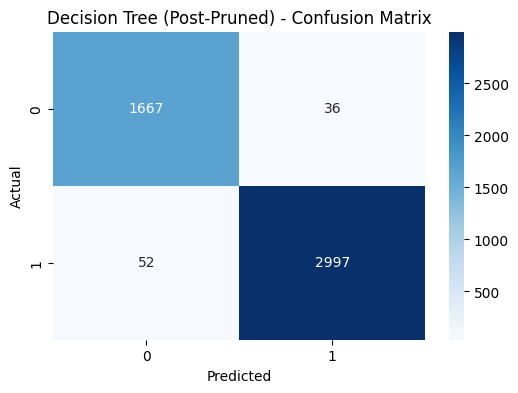

In [17]:
# Plot the confusion matrix for the post-pruned decision tree
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, dt_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree (Post-Pruned) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Tree Visualization (Top Levels):** To understand how pruning impacted the model, we visualize the top levels of the pruned decision tree.

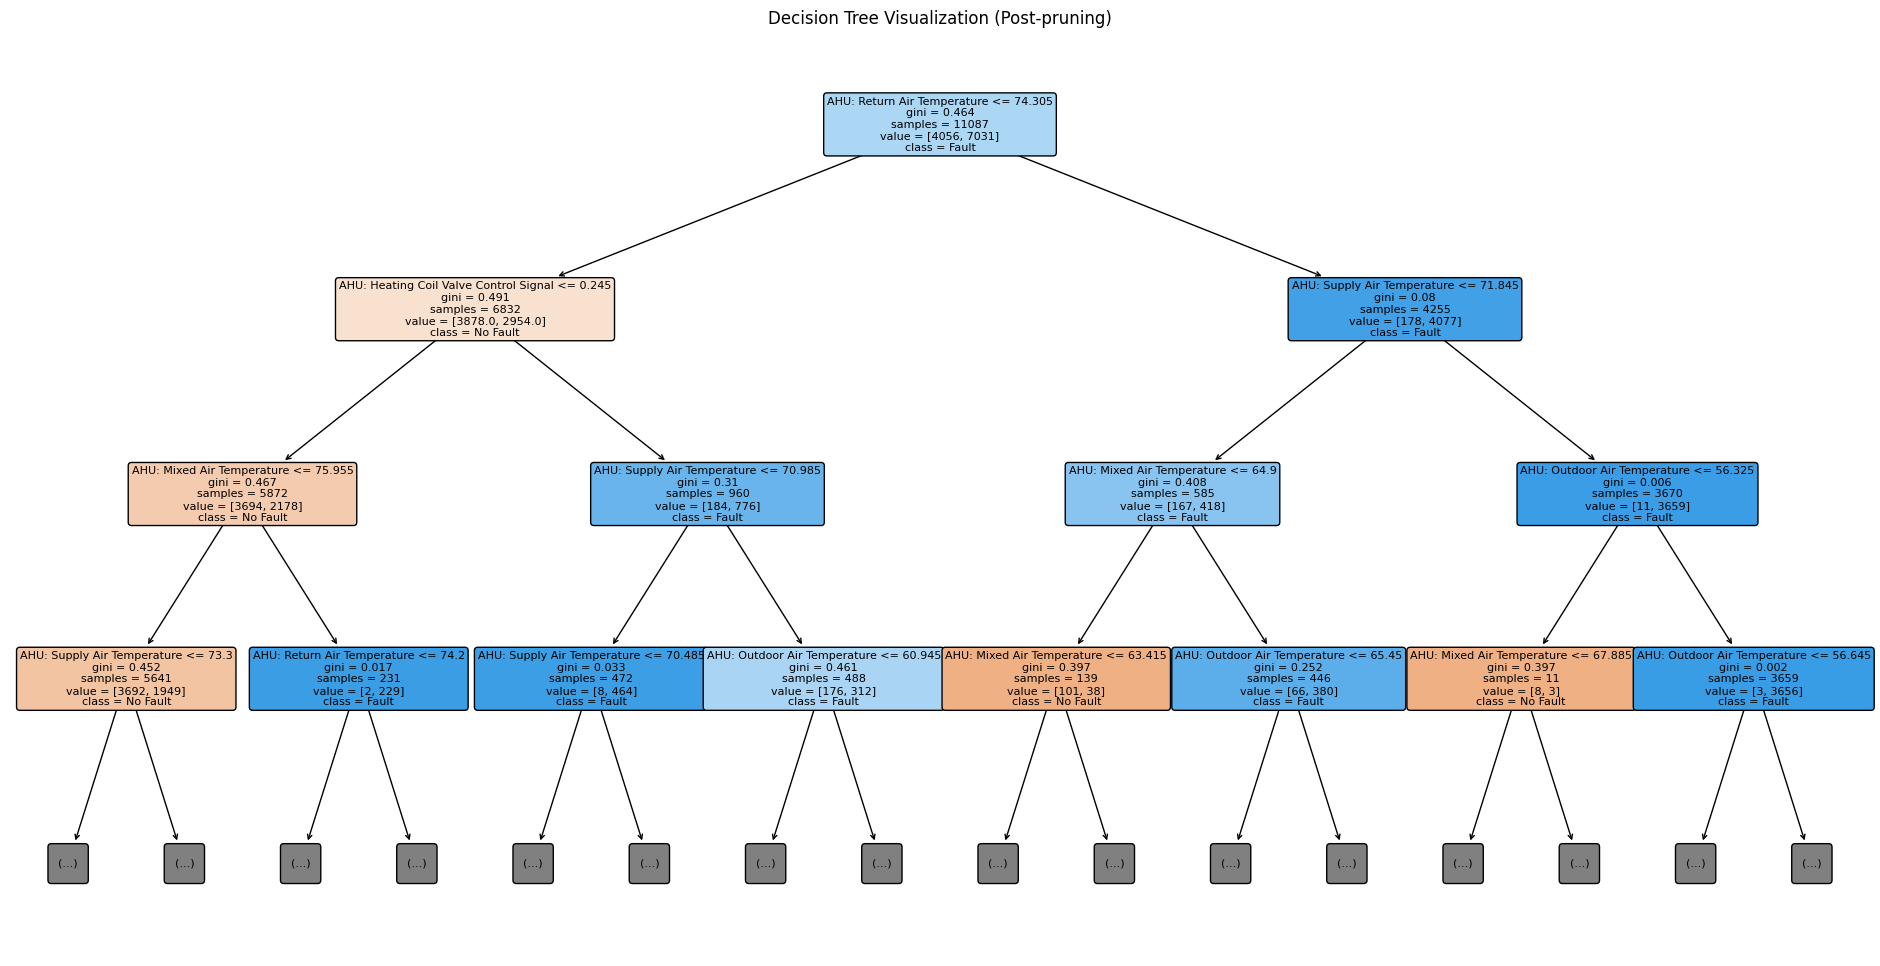

In [18]:
# Visualize the top levels of the post-pruned decision tree
plt.figure(figsize=(24, 12))
plot_tree(
    dt_model, 
    feature_names=X.columns, 
    class_names=["No Fault", "Fault"],
    filled=True,
    max_depth=3,  # show only top levels
    fontsize=8,
    rounded=True
)
plt.title("Decision Tree Visualization (Post-pruning)")
plt.show()




**Tree Structure Summary:** We print key structural information such as depth and number of leaf nodes for the post-pruned tree.

In [19]:
# Print basic structural metrics of the pruned decision tree
print("Tree Depth:", dt_model.get_depth())
print("Number of Leaf Nodes:", dt_model.get_n_leaves())


Tree Depth: 26
Number of Leaf Nodes: 172


**Tree Rules (Text Format):** The pruning effect can also be observed in the simplified decision rules.

In [20]:
# Display the decision rules for the post-pruned tree
tree_rules_post = export_text(dt_model, feature_names=list(X.columns))
print("\n Decision Tree Rules (Post-pruning):\n")
print(tree_rules_post)



 Decision Tree Rules (Post-pruning):

|--- AHU: Return Air Temperature <= 74.31
|   |--- AHU: Heating Coil Valve Control Signal <= 0.24
|   |   |--- AHU: Mixed Air Temperature <= 75.95
|   |   |   |--- AHU: Supply Air Temperature <= 73.30
|   |   |   |   |--- AHU: Supply Air Temperature <= 66.74
|   |   |   |   |   |--- AHU: Mixed Air Temperature <= 73.93
|   |   |   |   |   |   |--- AHU: Outdoor Air Damper Control Signal   <= 0.11
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- AHU: Outdoor Air Damper Control Signal   >  0.11
|   |   |   |   |   |   |   |--- AHU: Cooling Coil Valve Control Signal <= 0.37
|   |   |   |   |   |   |   |   |--- AHU: Heating Coil Valve Control Signal <= 0.08
|   |   |   |   |   |   |   |   |   |--- AHU: Outdoor Air Temperature <= 61.24
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- AHU: Outdoor Air Temperature >  61.24
|   |   |   |   |   |   |   |   |   |   |--- AHU: Cooling Coil Valv

**Feature Importance:** We compute and plot feature importance to understand which features had the greatest influence on predictions after pruning.

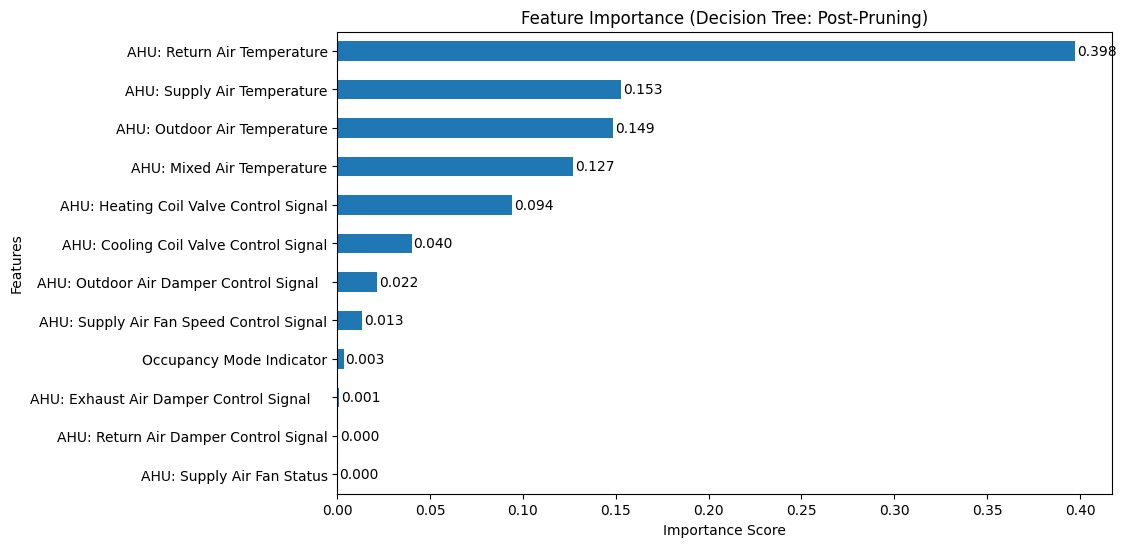

In [21]:
# Calculate and visualize feature importance for the post-pruned tree
importances = pd.Series(dt_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

ax = importances_sorted.plot(kind='barh', figsize=(10, 6))

# Annotate each bar with its importance score
for i, v in enumerate(importances_sorted):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.title('Feature Importance (Decision Tree: Post-Pruning)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


# **4. RANDOM FOREST**

This section focuses on building a Random Forest model with hyperparameter tuning using GridSearchCV. The model is evaluated on the test data, and performance metrics such as accuracy, OOB score, and feature importance are reported.

**Hyperparameter Tuning with GridSearchCV:** We define a grid of hyperparameters to control the ensemble of decision trees. The model is trained using 5-fold cross-validation to find the best combination for maximizing accuracy.

In [26]:
# Define the base Random Forest classifier
rf = RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300],         # Number of trees in the forest
    'max_depth': [20, None],            # Maximum depth of each tree
    'min_samples_split': [2, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4],         # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt']            # Number of features to consider when looking for the best split
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Train the Random Forest using grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [20, None], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 300]},
             return_train_score=True, scoring='accuracy', verbose=1)

**Evaluate Best Random Forest Model:** We extract the best model from the grid search and evaluate its performance using accuracy, OOB score, and classification metrics

In [23]:
# Retrieve the best model from grid search
best_rf = grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)

# Display the best hyperparameter combination
print("\n-> Best hyperparameter combination (Random Forest):")
print(grid_search.best_params_)

# Display performance metrics
print("\n-> Random Forest Results (Tuned):")
print("Test Accuracy:", accuracy_score(y_test, rf_preds))
print("OOB Score:", best_rf.oob_score_)
print("\n-> Classification Report:")
print(classification_report(y_test, rf_preds))


-> Best hyperparameter combination (Random Forest):
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

-> Random Forest Results (Tuned):
Test Accuracy: 0.9932659932659933
OOB Score: 0.9931451249210788

-> Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1703
           1       1.00      0.99      0.99      3049

    accuracy                           0.99      4752
   macro avg       0.99      0.99      0.99      4752
weighted avg       0.99      0.99      0.99      4752



**Confusion Matrix:** The confusion matrix provides insight into the classification accuracy across both classes.

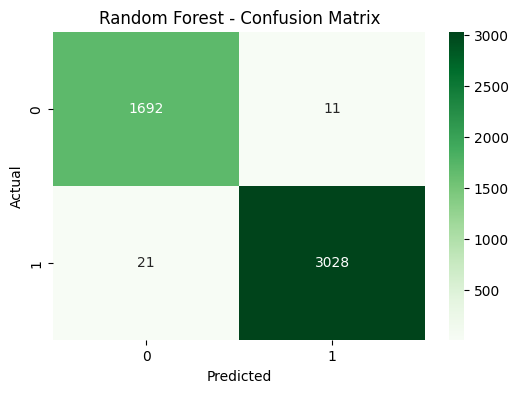

In [24]:
# Plot the confusion matrix for the tuned Random Forest model
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Feature Importance:** We analyze which features contributed most to the predictions made by the Random Forest model.

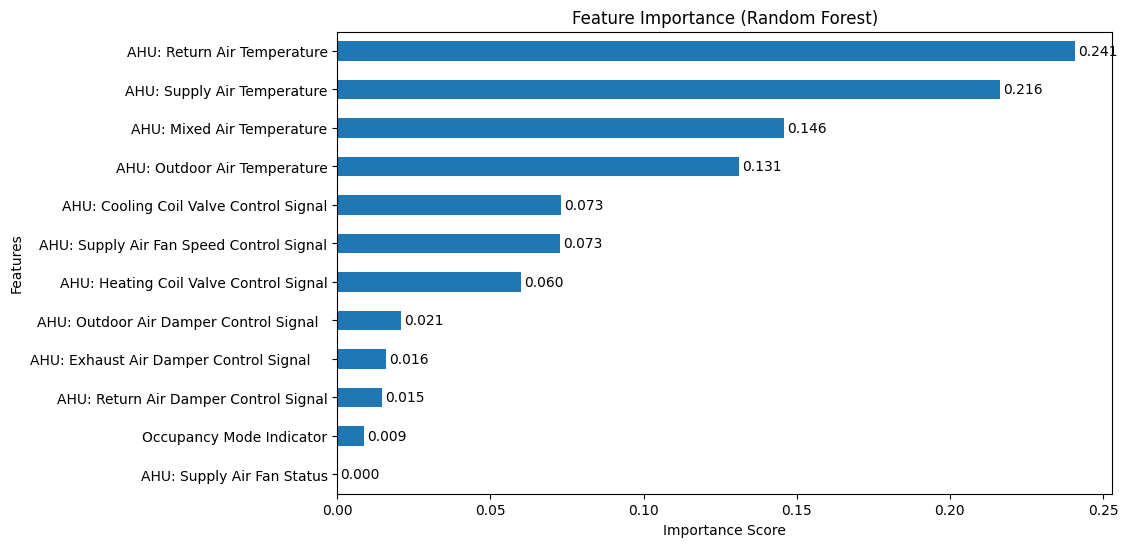

In [25]:
# Compute and plot feature importance for the Random Forest model
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

ax = importances_sorted.plot(kind='barh', figsize=(10, 6))

# Annotate each bar with its importance score
for i, v in enumerate(importances_sorted):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

**Conclusions:**

-   Tree-based classifiers are well-suited for diagnostic tasks, offering interpretable, rule-based structures for classification. Their hierarchical design makes them intuitive for fault detection in system monitoring applications such as HVAC control.
-   Splitting criteria (Gini Impurity and Entropy) and stopping conditions are core theoretical components in decision tree construction. Their proper implementation—particularly through the CART algorithm—led to effective and consistent model behavior.
-   Pruning strategies (pre- and post-pruning) effectively controlled model complexity. Post-pruning provided slight improvements in accuracy and reduced unnecessary branches, demonstrating its practical value in optimizing tree simplicity and performance.
-   All three models achieved high accuracy (above 98%), confirming the viability of tree-based methods for HVAC fault detection. However, the Random Forest classifier consistently outperformed both Decision Tree variants, achieving a test accuracy of 99.33% and an Out-of-Bag score of 99.31%.
-   Random Forest’s ensemble design—combining bootstrap sampling, feature randomness, and majority voting—contributed to better generalization, lower misclassification rates, and improved resilience to noise and data variability.
-   Out-of-Bag (OOB) estimation enabled efficient internal validation without requiring a separate hold-out set, further supporting the model's practicality and computational efficiency.
-   Confusion matrix analysis highlighted that Random Forest achieved the best trade-off between false positives and false negatives, which is critical for real-time HVAC diagnostics.
-   Feature importance analysis showed that Return Air Temperature was the top predictor across all models. Random Forest provided a more balanced distribution of importance, incorporating both temperature and control-related features.
-   While all three models demonstrated high classification capability and practical viability, the Random Forest classifier consistently delivered superior results in terms of accuracy, misclassification minimization, and comprehensive feature utilization. Its ensemble architecture made it the most robust and reliable option for fault detection in the evaluated SZVAV system.
-   Nonetheless, the Decision Tree models retain significant value—particularly in scenarios that prioritize model transparency, interpretability, or computational simplicity. Post-pruning proved useful for improving performance while maintaining diagnostic clarity.
-   The methodology followed represents a structured and reproducible framework that can be adapted for other diagnostic systems in building automation, combining theoretical grounding with practical model deployment.
-   Random Forest is the most effective and generalizable classifier for HVAC fault detection in this study. While Decision Trees offer interpretability and simplicity, Random Forest provides excellent robustness, making it the preferred choice for real-world implementation in building automation and energy efficiency solutions.
